In [1]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams



plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})    


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_eq = 1.59246e12/yr      # in units of seconds


σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3


m_1 = 7   #in units of M☉
m_2 = 9   #in units of M☉

y_1 = math.log(m_1)
y_2 = math.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(11)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (math.ceil(math.exp(y)))
    M_2_list[i] = (math.ceil(math.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = math.exp(y + 0.5*dy) - math.exp(y - 0.5*dy)
    Δ_2_list[i] = math.exp(y + 0.5*dy) - math.exp(y - 0.5*dy) 
        


def merger_rate(m_1,m_2,Δ_1,Δ_2,t_m):
    
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def λ(m_1, m_2, Δ_1, Δ_2, X):   #λ_0
        return  X/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))
    
    k = 19.4965
    A=((ρ_eq**(4/3))*(G**3)*(k**7))/(c**5)

    def B(m_1,m_2,Δ_1,Δ_2):
        return (A**(1/7)) * ((m_1 * m_2 * t_m)**(1/7)) *    ((m_1+m_2)**(-1/21)) * ((f_b(m_1,m_2))**(37/21))* ((f**2 + 1.2009*(σ_eq**2))**(-1/2)) * ((Δ_1*Δ_2)**(37/42))
    
    
    X = np.geomspace(1e-5, 1e5, 1000000) 
   
    
    def γ_X(m_1,m_2,Δ_1,Δ_2, X):        #eq.(12) in the notes.
        return (((1 + 0.1709 * λ(m_1, m_2, Δ_1, Δ_2, X))**(-1/14))/(1 + 0.0136 * λ(m_1, m_2, Δ_1, Δ_2, X))) *  B(m_1,m_2,Δ_1,Δ_2) * (X**(-37/21))
    
    def PDF(m):
        return (P(m)/m)

    
    I = quad(PDF, 5, np.inf)             # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                                         # 0 to infinity.
    
    n_T = f * ρ_eq * I[0]                #n_T=f*ρ_eq∫(P(m)/m)*dm 
    
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
    
    
    def integrand(m_1,m_2,Δ_1,Δ_2, X):
        return  np.exp(-((4*π)/3)  * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T * X) * ((γ_X(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2)))

    
    
    return (1/(14 * t_m)) *  ρ_m *  ((f**2)/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))) *  (m_1 + m_2) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2)  * (np.trapz(integrand(m_1,m_2,Δ_1,Δ_2, X),X)) 


In [2]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2 with Δ_1=Δ_2=Δ.


Merger_PWR = np.zeros((11, 11))



for i in range(11):
    for j in range(11):
        
        f_pbh = 4.3e-3
        f = 0.85*f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merger_PWR[i,j] = 0.5*merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], t_m)
            
        else:
            Merger_PWR[i,j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], t_m)   
    
        

np.save("Merger_PWR", Merger_PWR)

In [3]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2 with Δ_1=Δ_2=Δ.



Merger_Lognormal = np.zeros((11, 11))


for i in range(11):
    for j in range(11):
        
        f_pbh = 3.7e-3
        f = 0.85*f_pbh 
        
        def P(m):               #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉
            return  math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))/(σ*m*math.sqrt(2*π))

        if i==j:
            Merger_Lognormal[i, j] = 0.5 * merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], t_m)
            
        else:
            Merger_Lognormal[i, j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], t_m)
            



np.save("Merger_Lognormal", Merger_Lognormal)

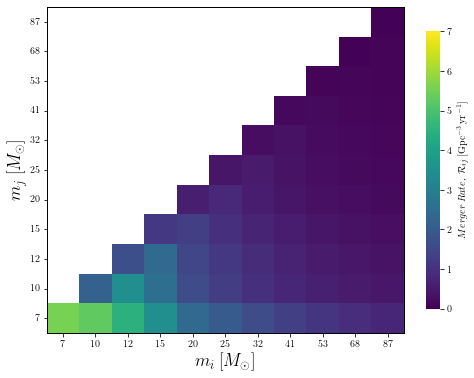

In [4]:

plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



Merger_PWR = np.load('Merger_PWR.npy')





mask = np.tril(np.ones((11,11)), k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(8, 6))  





ax = sns.heatmap(Merger_PWR, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 0.85,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 vmin = 0, vmax = 7)



ax.set_xticklabels(m_1_list)
ax.set_yticklabels(m_2_list,rotation = 360)
ax.tick_params(left=True, bottom=True)




# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)


ax.invert_yaxis()
plt.xlabel('$m_{i}\:[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('PWRLawnoDM.pdf')
plt.show()     

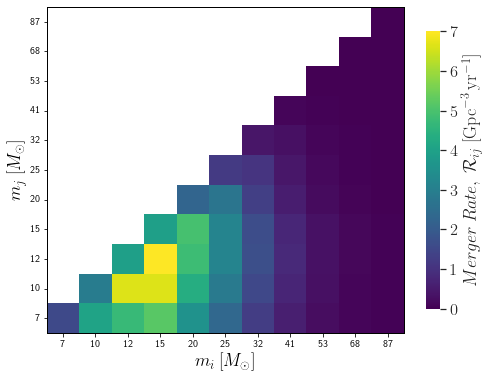

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'






Merger_Lognormal = np.load('Merger_Lognormal.npy')



mask = np.tril(np.ones((11,11)),k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(8, 6))  


sns.set(font_scale=1.5)

ax = sns.heatmap(Merger_Lognormal, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 0.85,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 vmin = 0, vmax = 7, clip_on=False)


ax.set_xticklabels(m_1_list)
ax.set_yticklabels(m_2_list,rotation = 360)
ax.tick_params(left=True, bottom=True)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

ax.invert_yaxis()
plt.xlabel('$m_{i}\: [M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('LogNormalnohalos.pdf')
plt.show()     

In [6]:
Merger_PWR = np.load('Merger_PWR.npy')

Merger_Lognormal = np.load('Merger_Lognormal.npy')



print("Merger_PWR =", Merger_PWR)
print('\v')
print("Merger_Lognormal =", Merger_Lognormal)

Merger_PWR = [[5.56206629 5.29988038 4.47068424 3.46896715 2.39980451 1.98416903
  1.59659418 1.30783955 1.0706197  0.8986618  0.76411536]
 [5.29988038 2.15146288 3.44920899 2.50338844 1.59317105 1.25604611
  0.96618134 0.76388049 0.60782113 0.49981316 0.41851759]
 [4.47068424 3.44920899 1.69231618 2.38936618 1.46589709 1.13003476
  0.85021036 0.66009312 0.51738993 0.42069475 0.34925485]
 [3.46896715 2.50338844 2.38936618 1.12691571 1.30971291 0.97566104
  0.70900158 0.53470923 0.40902211 0.32656077 0.26735072]
 [2.39980451 1.59317105 1.46589709 1.30971291 0.57655753 0.81362671
  0.55792487 0.40002141 0.29287217 0.22614115 0.18043296]
 [1.98416903 1.25604611 1.13003476 0.97566104 0.81362671 0.38353814
  0.50326773 0.34640804 0.24436752 0.18320476 0.1427958 ]
 [1.59659418 0.96618134 0.85021036 0.70900158 0.55792487 0.50326773
  0.23143184 0.30262454 0.20322535 0.14629749 0.11031733]
 [1.30783955 0.76388049 0.66009312 0.53470923 0.40002141 0.34640804
  0.30262454 0.138947   0.17674901 0.